# Proton ID training example

Code is located here: https://github.com/k-woodruff/protonid

There is a python script (boost_multi.py) that imports XGBoost (https://github.com/dmlc/xgboost) and trains a gradient-boosted decision tree classifier. There are three useful functions: load_data(), run_cv(), and make_bdt(). This example shows how to use these functions.

This script uses protons from BNB MC and protons from cosmic MC as the target (positive) class. It has four negative classes: BNB MC muons, BNB MC pions, BNB MC EM shower tracks, and BNB non-proton cosmics. It can easily be edited to use any set of reconstructed tracks as the target class or background classes. 

### Getting csv files from analysis tree
There are currently two ways of getting all of the reconstructed features used out of the analysis tree files.

1. There is a ROOT macro that you can find here:
/uboone/app/users/kwoodruf/ana2csv/ana2csv_bnbcos.C
(It is pretty bloated and inefficient.)

2. Erez Cohen wrote a larlite module that is much faster and more efficient to get these variables out. You can contact him on how to use it.

If you just want to look at MCC7 monte carlo samples, I can point you to where csv files already exist.

In [1]:
import boost_multi

The load_data() functions doesn't take any arguments. The csv files and class labels are hard coded into the script.

It returns numpy arrays with the training data and the corresponding class labels and weights.

In [2]:
data,label,weight = boost_multi.load_data()

## Running cross validation

The run_cv() function runs cross validation using the training data. It takes in the data, labels, and weights that are returned by load_data(). It returns numpy arrays containing the the test error (and false positive and negative fractions) for each fold. It also returns a large numpy array that contains the CV scores for every single one of the training samples. You may or may not want to comment that part out.

All of the CV and classifier hyperparameters are hard-coded in and should be edited. In this example, to keep things quick and easy, we use 50 trees, a small subset of the data, and 5-fold, stratified CV. The classifier hyperparameters were determined using a much larger number of trees and number of samples using the hyperopt library (https://github.com/dmlc/xgboost). You should definitely look at the XGBoost documentation to learn about what these parameters mean.

In [3]:
test_error,test_falsepos,test_falseneg,scores = boost_multi.run_cv( data,label,weight )

On fold 0
Fold error: 0.0676
On fold 1
Fold error: 0.0652
On fold 2
Fold error: 0.0691
On fold 3
Fold error: 0.0670
On fold 4
Fold error: 0.0681


We can look at error and variance from cross-validation:

(remember that the results should improve when you use an appropriate amount of samples and trees)

In [6]:
print 'CV error: %.4f +/- %.4f' %(np.array(test_error).mean(),np.array(test_error).std())

CV error: 0.0674 +/- 0.0013


### Interpreting the CV predictions

The output array "scores" is a 6-dimensional array.
The first column is the probability of each sample to be a proton,
the second through fifth columns are the probabilities for each sample to be a muon, pi, em, or cosmic track.
The last column is the monte carlo truth label of the sample
(0 = proton, 1 = muon, 2 = pion, 3 = electron or photon, 4 = cosmic).

The following lines pull out 5-D arrays of scores for each mc particle in the training set:

In [7]:
proton_scores = scores[0:5,scores[5,:] == 0]
muon_scores   = scores[0:5,scores[5,:] == 1]
pion_scores   = scores[0:5,scores[5,:] == 2]
em_scores     = scores[0:5,scores[5,:] == 3]
cosmic_scores = scores[0:5,scores[5,:] == 4]

We can now plot the distribution of proton scores (first column in scores) for each particle type.
We could do the same for the probability of being a muon or pion, etc.

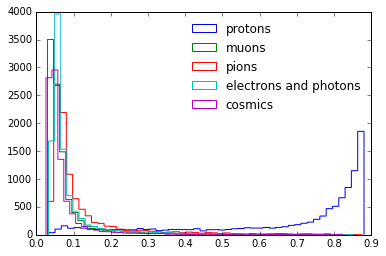

In [8]:
plt.hist(proton_scores[0],bins=50,histtype='step',label='protons');
plt.hist(muon_scores[0]  ,bins=50,histtype='step',label='muons');
plt.hist(pion_scores[0]  ,bins=50,histtype='step',label='pions');
plt.hist(em_scores[0]    ,bins=50,histtype='step',label='electrons and photons');
plt.hist(cosmic_scores[0],bins=50,histtype='step',label='cosmics');
plt.legend(loc='upper right',frameon=False);

## Train and save the classifier for production

Once we are satisfied with how the trees behave, we can train on all of the data and save the model. All of the same hyperparameters should be used here that were used for cross validation. We have already loaded the data in the first step, so we don't need to do it again. 

In [9]:
bdt = boost_multi.make_bdt( data,label,weight )

Save this to use later to predict data:

In [11]:
bdt.save_model('bdts/multi.bst')

We can also look at what the important features are. These are the most common variables that the trees used to split the data.

First print the feature names for reference (copied from python script):

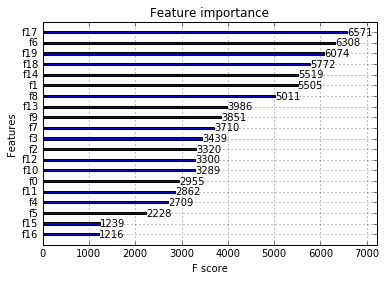

In [13]:
features = ['nhits','length','starty','startz','endy','endz','theta','phi',
            'distlenratio','startdqdx','enddqdx','dqdxdiff','dqdxratio',
            'totaldqdx','averagedqdx','cosmicscore','coscontscore',
            'pidpida','pidchi','cfdistance']
import xgboost as xgb
ax = xgb.plot_importance(bdt);

I haven't spent the time to figure out an elegant way to match the 
features to the labels on the importance plot yet
for now we can look one-by-one

In [15]:
# the three most important features are 17, 18, and 19:
print 'Most important features:'
print '1. %s' %features[17]
print '2. %s' %features[18]
print '3. %s' %features[19]

Most important features:
1. pidpida
2. pidchi
3. cfdistance


In [18]:
# the three least important are 5, 15, and 16
print 'Least important features:'
print '18. %s' %features[5]
print '19. %s' %features[15]
print '20. %s' %features[16]

Least important features:
18. endz
19. cosmicscore
20. coscontscore


To use the BDT model to predict, you can use predict_multi.py script. An example of how to use this is in the score_example.ipynb notebook.